# Clustering of transcripts upstream of TSS

Work on clustering transcripts using their conservation score 1 kb upstream of TSS:
- slice
- intersect w/conservation scores
- 10 bp bins
- avg score w/in bins
- table
- standardize
- cluster! 

First we import necessary modules:

In [1]:
import gffutils
from gffutils import pybedtools_integration
import pybedtools
from pybedtools.featurefuncs import gff2bed
import pandas as pd
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
import scipy.stats as stats

Import database and define transcripts, genes, tsses, etc. 

In [25]:
db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.gtf.db')

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [ ]:
transcripts = pybedtools_integration.to_bedtool(db.features_of_type('transcript')).saveas()

In [ ]:
genes = pybedtools_integration.to_bedtool(db.features_of_type('gene')).sort().merge().saveas()

In [26]:
tss = pybedtools_integration.tsses(db, merge_overlapping=False).saveas('../../output/tsses.gff')

In [ ]:
slop = tss.slop(l=1000, r=0, s=True, genome='dm6').saveas('../../output/another_slop.bed')

Get intersections TSS w/exons, TSS w/introns, TSS w/intergenic:

In [ ]:
TSS_exons = tss.intersect('../../output/dm6_exons.bed').saveas().to_dataframe()

In [ ]:
introns = pd.read_table('../../output/dmel-introns-r6.11.gff', header=None)

In [ ]:
introns[0] = [ 'chr'+x for x in introns[0] ] 

In [ ]:
tss_introns = tss.intersect(pybedtools.BedTool.from_dataframe(introns), wa=True).saveas().to_dataframe()

In [ ]:
TSS_intergenic = tss.intersect('../../output/intergenic.bed').saveas().to_dataframe()

break up upstream region into 10 bp bins, with average conservation score for each window. In order to do that,  
- split by chromosome
- group by location
- for each position make windows, then intersect with phastcons, then take that and agg over scores
- add back gene/transcript info 

In [ ]:
#wig2bed < dm6.27way.phastCons.wigFix > dm6_phastcons.bed
phastcons = pybedtools.BedTool('../../output/dm6_phastcons.bed').saveas()

In [4]:
tsses = pd.read_table('../../output/motif/another_slop.bed', header=None)

### 2L

In [5]:
tsses_2L = tsses[tsses[0] == 'chr2L']

In [6]:
tsses_2L[8] = [ x.split()[3].strip(';').strip('"') for x in list(tsses_2L[8]) ]


/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
tsses_2L = tsses_2L.groupby([0,3,4])[8].apply(lambda x:'|'.join(x)).reset_index()
tsses_2L.head()

,0,3,4,8
0,chr2L,6529,7529,FBtr0300689|FBtr0300690|FBtr0330654
1,chr2L,18570,19570,FBtr0078170|FBtr0078171
2,chr2L,20952,21952,FBtr0309810
3,chr2L,21376,22376,FBtr0078168|FBtr0078166|FBtr0078167|FBtr007816...
4,chr2L,25155,26155,FBtr0113008


In [8]:
phastcons = pybedtools.BedTool('../../output/motif/2L_phastcons.bed').saveas()

In [ ]:
#because the loop ran too long and I had to break up into two days: 
done = pd.read_csv('../../output/motif/done_from_today', header=None)
done_vals = []
for x, y in done.iterrows():
    if list(y) not in done_vals:
        done_vals.append(list(y))

for name, group in tsses_2L.groupby([3,4]):
    if [str(name), str(group)] not in done_vals:
        print([str(name), str(group)])
        break

WARNING: this takes a really long time, get windows with avg phastcons score by position

In [ ]:
def make_bins(chrom,a,b,n):
    bins = pd.cut([a,b], n, retbins=True, include_lowest=True)[1]
    collect = []
    for i in range(n):
        collect.append([chrom, int(list(bins)[i:i+2][0]), int(list(bins)[i:i+2][1])])
    return collect

errors=[]
for name, group in tsses_2L.groupby([3,4]):
    if [str(name), str(group)] not in done_vals:
        concat=[]
        done_vals.append([str(name), str(group)])
        bins = make_bins(list(group[0])[0], name[0], name[1], 100)
        df = pd.DataFrame(bins)
        intersect = pybedtools.BedTool.from_dataframe(df).intersect(phastcons, wo=True)
        try:
            intersect = intersect.to_dataframe()
            agg = intersect.groupby(['chrom', 'start', 'end']).agg({'thickEnd':'mean'}).reset_index()
            with_name = agg.copy()
            with_name['name'] = list(group[8])[0]
            concat.append(with_name)
            final = pd.concat(concat)
            final = final[['chrom','start','end','name','thickEnd']]
            final.to_csv('../../output/motif/tss_windows_wphastcons_3', sep='\t', header=None, index=False, mode='a')
        except: 
            errors.append(name)
        pd.DataFrame(done_vals).to_csv('../../output/motif/done_herewegoagain', header=None, index=False, mode='a')

In [2]:
#this actually finished!! 
df = pd.read_table('../../output/motif/tss_windows_wphastcons_3', header=None)

Make sure everything is there: 

In [10]:
alldone = pd.read_csv('../../output/motif/done_herewegoagain', header=None)
alldone.head()

,0,1
0,"(6529, 7529)",0 3 4 ...
1,"(18570, 19570)",0 3 4 ...
2,"(20952, 21952)",0 3 4 8\n2 chr2L ...
3,"(21376, 22376)",0 3 4 ...
4,"(25155, 26155)",0 3 4 8\n4 chr2L ...


In [11]:
done_vals_2 = []
for x, y in alldone.iterrows():
    if list(y) not in done_vals_2:
        done_vals_2.append(list(y))
        
for name, group in tsses_2L.groupby([3,4]):
    if [str(name), str(group)] not in done_vals_2:
        print([str(name), str(group)])

# Clustering

Put data into a table [transcript group x bin]

Name bins from 0-99, then pivot the dataframe:

In [3]:
df['bin'] = df.groupby([3]).cumcount()
df.head()

,0,1,2,3,4,bin
0,chr2L,6528,6539,FBtr0300689|FBtr0300690|FBtr0330654,0.078182,0
1,chr2L,6539,6549,FBtr0300689|FBtr0300690|FBtr0330654,0.100600,1
2,chr2L,6549,6559,FBtr0300689|FBtr0300690|FBtr0330654,0.002000,2
3,chr2L,6559,6569,FBtr0300689|FBtr0300690|FBtr0330654,0.004700,3
4,chr2L,6569,6579,FBtr0300689|FBtr0300690|FBtr0330654,0.015100,4


In [4]:
df.dropna(how='all', inplace=True)

In [12]:
pivot = df.pivot(index=3, columns='bin', values=4)

In [13]:
#come back to look at these closer? for now just dropping
lost = pivot[pivot.isnull()].index.unique()

In [14]:
df[df[df[3] == lost[0]].isnull()]

,0,1,2,3,4,bin
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
newpivot = pivot.dropna()

IndexError: list index out of range

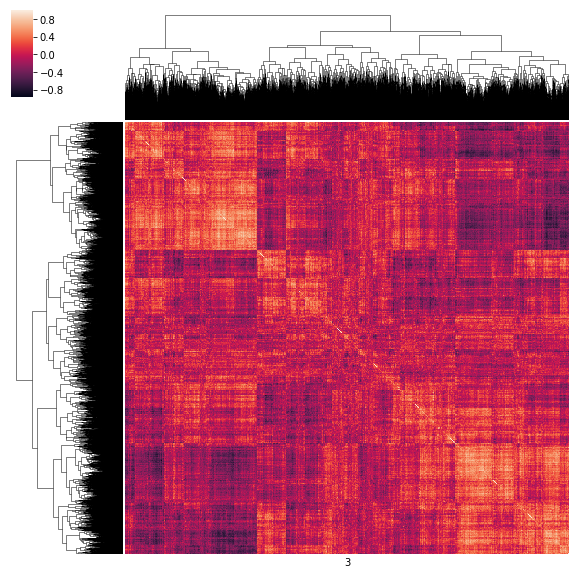

In [15]:
#to make sure clustering is worth it: 
sb.clustermap(newpivot.T.corr(), xticklabels=False, yticklabels=False)

### Perform a PCA: 

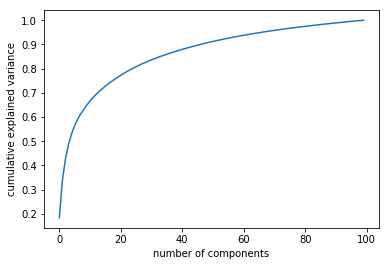

In [16]:
pca = PCA().fit(newpivot)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Decided to use 4 components:

In [17]:
#X = StandardScaler().fit_transform(newpivot)
X = np.array(newpivot)
pca = PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (4326, 100)
transformed shape: (4326, 4)


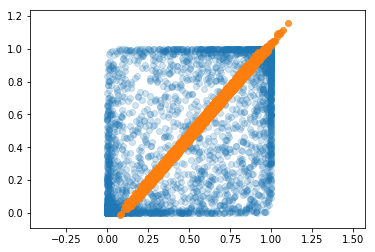

In [18]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

### KMeans clustering: 

In [19]:
kmeans = KMeans()
clusters = kmeans.fit_predict(X_pca)
kmeans.cluster_centers_.shape

(8, 4)

In [20]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

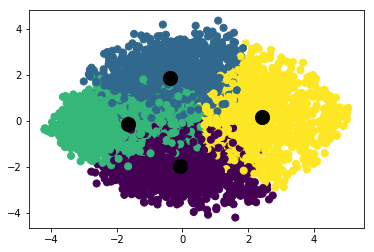

In [21]:
centers = kmeans.cluster_centers_

plt.scatter(X_pca[:, 0], X_pca[:,1], c=y_kmeans, cmap='viridis', s=50)
plt.scatter(centers[:,0], centers[:,1], c='black', s=200)

In [22]:
cluster_nums = pd.DataFrame(y_kmeans)
clustermap = pd.DataFrame(newpivot.index.values)
clustermap['cluster'] = cluster_nums
clustermap.head()

,0,cluster
0,FBtr0005088|FBtr0339789|FBtr0100535|FBtr030610...,0
1,FBtr0077376,2
2,FBtr0077378,3
3,FBtr0077381,0
4,FBtr0077382,0


## Separate into individual bed files based on cluster: 
(These will be used to make heatmaps using ```deeptools```)

In [27]:
tssbed = tss.each(gff2bed).saveas('../../output/motif/tsses.bed').to_dataframe()

In [28]:
#split out the transcripts:
s = clustermap[0].str.split('|').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'name'
del clustermap[0]
expanded = clustermap.join(s)

In [29]:
cluster0 = expanded[expanded.cluster == 0]
cluster1 = expanded[expanded.cluster == 1]
cluster2 = expanded[expanded.cluster == 2]
cluster3 = expanded[expanded.cluster == 3]

In [30]:
zero = cluster0.merge(tssbed, on='name', how='left')
zero[['chrom'
      ,'start','end','name','score','strand']].to_csv('../../output/motif/cluster0.bed', header=None, sep='\t', index=False)

In [31]:
one = cluster1.merge(tssbed, on='name', how='left')
one[['chrom','start','end','name','score','strand']].to_csv('../../output/motif/cluster1.bed', header=None, sep='\t', index=False)

In [32]:
two = cluster2.merge(tssbed, on='name', how='left')
two[['chrom','start','end','name','score','strand']].to_csv('../../output/motif/cluster2.bed', header=None, sep='\t', index=False)

In [33]:
three = cluster3.merge(tssbed, on='name', how='left')
three[['chrom','start','end','name','score','strand']].to_csv('../../output/motif/cluster3.bed', header=None, sep='\t', index=False)

### Next: 
- make heatmaps using cluster specific beds
- build dummie matrix
- use dummie matrix to ask/answer questions!! 

In [34]:
dummie = pd.get_dummies(expanded.set_index('name').unstack())
dummie.head()

0  1  2  3
        name                   
cluster FBtr0005088  1  0  0  0
        FBtr0339789  1  0  0  0
        FBtr0100535  1  0  0  0
        FBtr0306102  1  0  0  0
        FBtr0100533  1  0  0  0

Summarize to gene level: 


In [35]:
my_map = pd.DataFrame([x.split(';')[0].split()[1].strip('"') for x in tss.to_dataframe()['attributes']], columns=['gene'])
my_map['name'] = [x.split(';')[1].split()[1].strip('"') for x in tss.to_dataframe()['attributes']]

In [36]:
dummie.reset_index(inplace=True)
del dummie['level_0']
dummie = dummie.merge(my_map, on='name', how='left')
dummie.head()

,name,0,1,2,3,gene
0,FBtr0005088,1,0,0,0,FBgn0260439
1,FBtr0339789,1,0,0,0,FBgn0260439
2,FBtr0100535,1,0,0,0,FBgn0260439
3,FBtr0306102,1,0,0,0,FBgn0260439
4,FBtr0100533,1,0,0,0,FBgn0260439


In [37]:
genedummie = dummie.groupby(['gene']).agg('sum')
genedummie['transcript#'] = genedummie.sum(axis=1)
genedummie.head()

,0,1,2,3,transcript#
gene,,,,,
FBgn0000018,0,1,0,0,1
FBgn0000052,1,1,0,1,3
FBgn0000053,0,0,0,3,3
FBgn0000055,0,0,2,3,5
FBgn0000056,0,0,2,1,3


In [38]:
mask = genedummie > 0 

In [39]:
mask[0].sum(axis=0)

988

In [40]:
mask[1].sum(axis=0)

978

In [41]:
mask[2].sum(axis=0)

1036

In [42]:
mask[3].sum(axis=0)

864

In [43]:
mask_copy = mask[[0,1,2,3]]
mask_copy['sum'] = (mask.sum(axis=1) - 1)
mask_copy.head()

,0,1,2,3,sum
gene,,,,,
FBgn0000018,False,True,False,False,1
FBgn0000052,True,True,False,True,3
FBgn0000053,False,False,False,True,1
FBgn0000055,False,False,True,True,2
FBgn0000056,False,False,True,True,2


In [44]:
# number of genes in all four clusters
in_all_four = mask_copy[mask_copy['sum'] == 4].index.values
len(set(in_all_four))

8

In [45]:
# number of genes in 3
in_three = mask_copy[mask_copy['sum'] == 3].index.values
len(set(in_three))

56

In [46]:
# number of genes in only 1 cluster
in_one = mask_copy[mask_copy['sum'] == 1].index.values
len(set(in_one))

2940

In [47]:
# total number of genes
len(set(mask_copy.index.values))

3367

In [48]:
genedummie['transcript#'].value_counts(normalize=False, sort=True)

1     1898
2      848
3      284
4      141
5       71
6       37
7       28
8       13
9       13
10      11
11       9
12       8
13       2
21       1
14       1
16       1
18       1
Name: transcript#, dtype: int64

Build contingency matrix using the genes with more than one TSS and the genes with transcripts in one cluster: 

In [49]:
gene_tss_count = pd.DataFrame(mask_copy['sum']).merge(my_map, left_index=True, right_on='gene', how='inner')
gene_tss_count = gene_tss_count.merge(tssbed[['start','end','name']], on='name',how='left')

In [50]:
gene_tss_count = gene_tss_count.groupby(['gene', 'sum']).agg({'start': 'nunique'}).reset_index()
gene_tss_count.columns = ['gene','cluster_count','tss_count']
gene_tss_count.head()

,gene,cluster_count,tss_count
0,FBgn0000018,1,1
1,FBgn0000052,3,3
2,FBgn0000053,1,1
3,FBgn0000055,2,2
4,FBgn0000056,2,3


In [51]:
pd.crosstab(gene_tss_count['tss_count'] > 1, gene_tss_count['cluster_count'] == 1, margins=True)

cluster_count,False,True,All
tss_count,,,
False,0,2646,2646
True,427,294,721
All,427,2940,3367


In [52]:
table = pd.crosstab(gene_tss_count['tss_count'] > 1, gene_tss_count['cluster_count'] == 1)

Fisher's Exact Test: 

In [53]:
stats.fisher_exact(table.values, alternative='two-sided')

(0.0, 0.0)

We're interested in the group of 292 genes with more than one TSS that are all in the same cluster. Pull out the gene lists for a GO analysis: 

In [54]:
sig_genes = gene_tss_count[(gene_tss_count['tss_count'] > 1) & (gene_tss_count['cluster_count'] == 1)].gene

In [55]:
sig_genes.to_csv('../../output/motif/sig_genes', sep='\t', header=None, index=False)

In [56]:
background = gene_tss_count.gene.to_csv('../../output/motif/background', sep='\t', header=None, index=False)

The GO showed most of these genes to be ribosomal/mitochondrial components. Next we asked if there are any trends as to what clusters these genes fall in: 

In [57]:
sig_genes_clusters = pd.DataFrame(sig_genes).merge(genedummie, left_on='gene', right_index=True, how='left')

In [58]:
(sig_genes_clusters > 0).sum()

gene           294
0               69
1               80
2               54
3               91
transcript#    294
dtype: int64

These genes seemingly fall in all four clusters. Unsure where we're going next with this... 

Also, check orthologs. 

In [59]:
#list of fbgns that have an ortholog in another species
orthologs = pd.read_table('/data/Oliverlab/data/orthologs/flyBase_orthoDB_one2one/7530.dmel.FBgns', header=None, names=['gene'])
orthologs.head()

,gene
0,FBgn0000008
1,FBgn0000014
2,FBgn0000015
3,FBgn0000017
4,FBgn0000018


In [60]:
orthodummie = orthologs.merge(genedummie, left_on='gene', right_index=True, how='inner')
orthodummie.head()

,gene,0,1,2,3,transcript#
4,FBgn0000018,0,1,0,0,1
12,FBgn0000052,1,1,0,1,3
13,FBgn0000053,0,0,0,3,3
14,FBgn0000056,0,0,2,1,3
16,FBgn0000061,0,1,0,0,1


In [61]:
orthodummie.shape

(1366, 6)

In [63]:
orthodummie.sum(axis=0)

gene           FBgn0000018FBgn0000052FBgn0000053FBgn0000056FB...
0                                                            894
1                                                            834
2                                                            663
3                                                            890
transcript#                                                 3281
dtype: object